# Week 31

## 1. Varying Training Ratio (Robustness Test)

Test robustness by changing the fraction of training links.

This runs the model with different split ratio: **60%, 65%, ... , 80%**

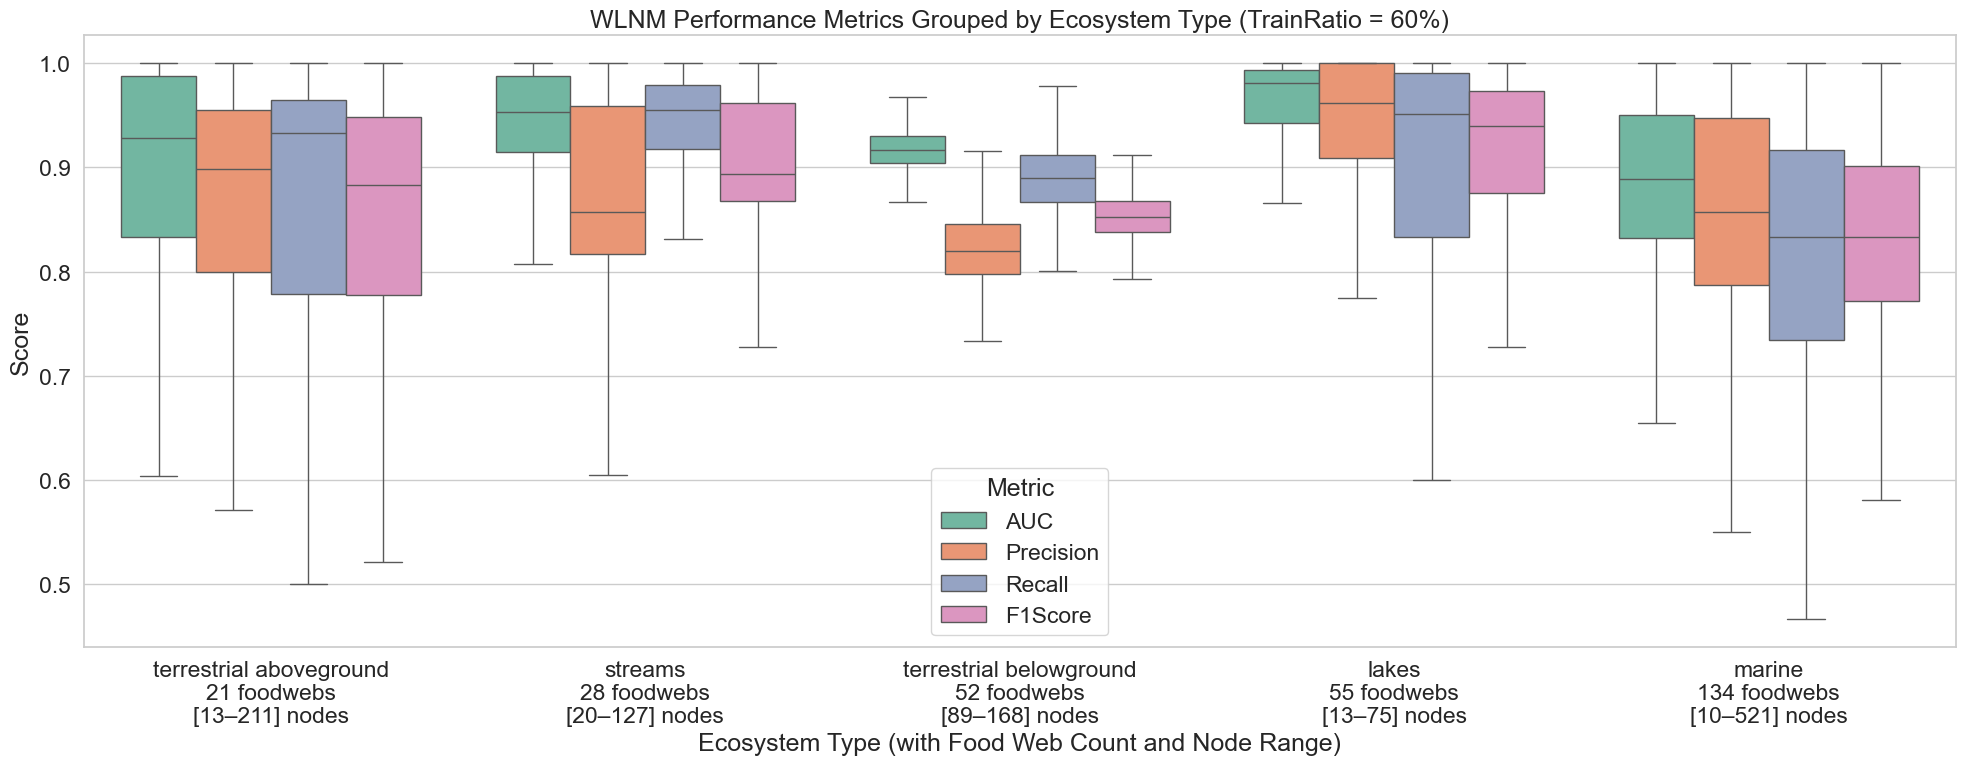

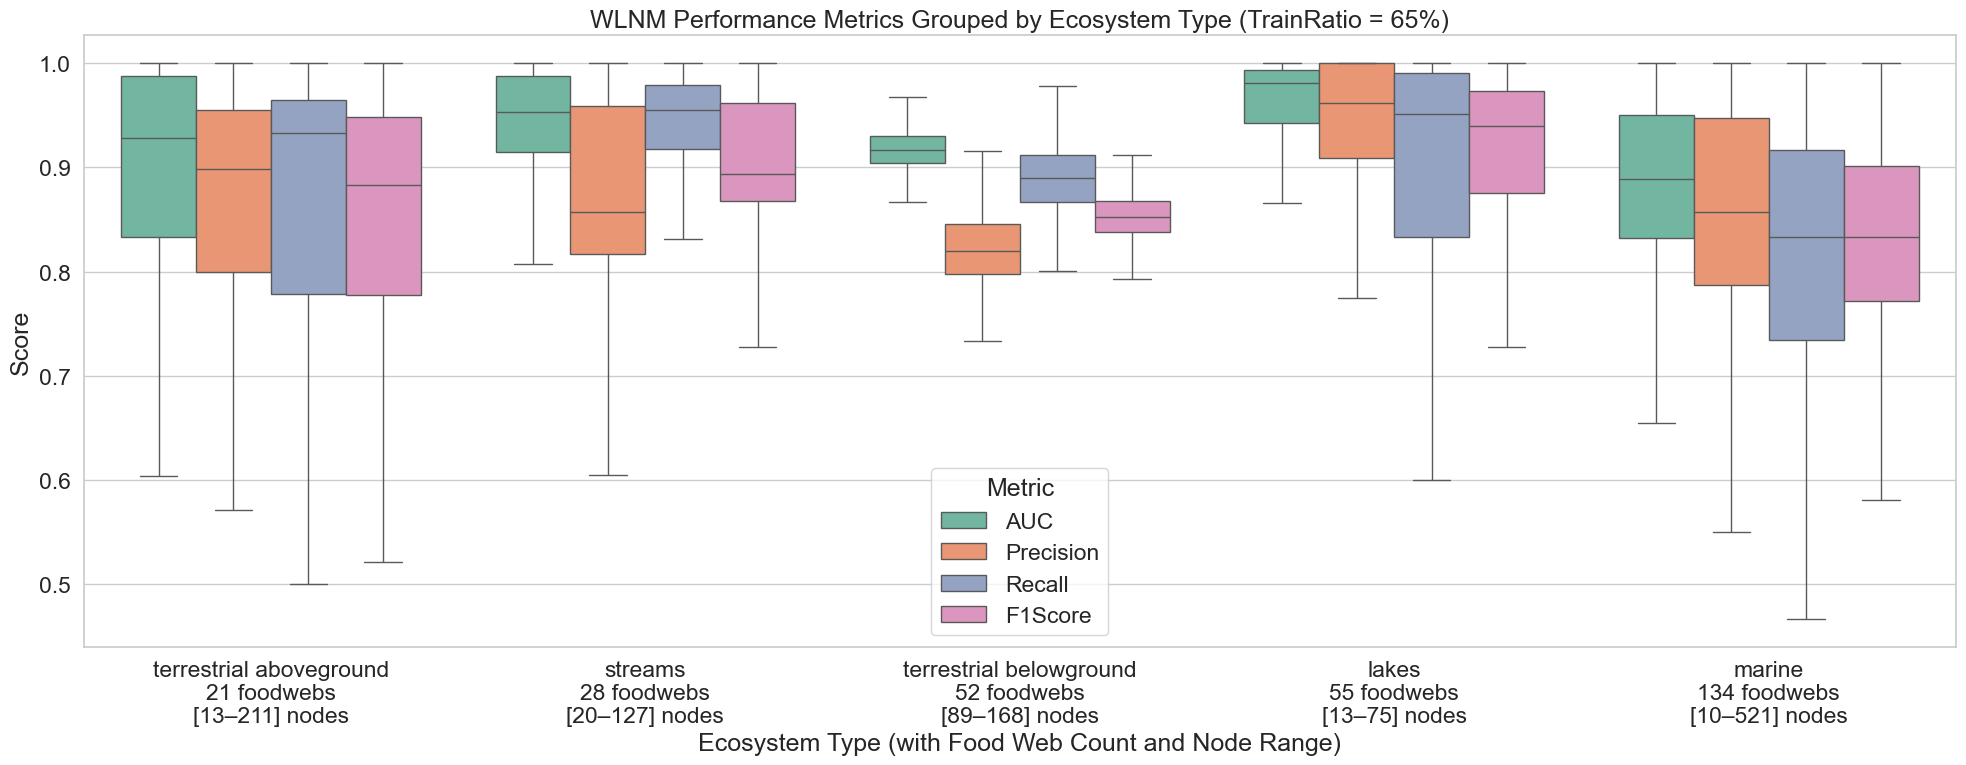

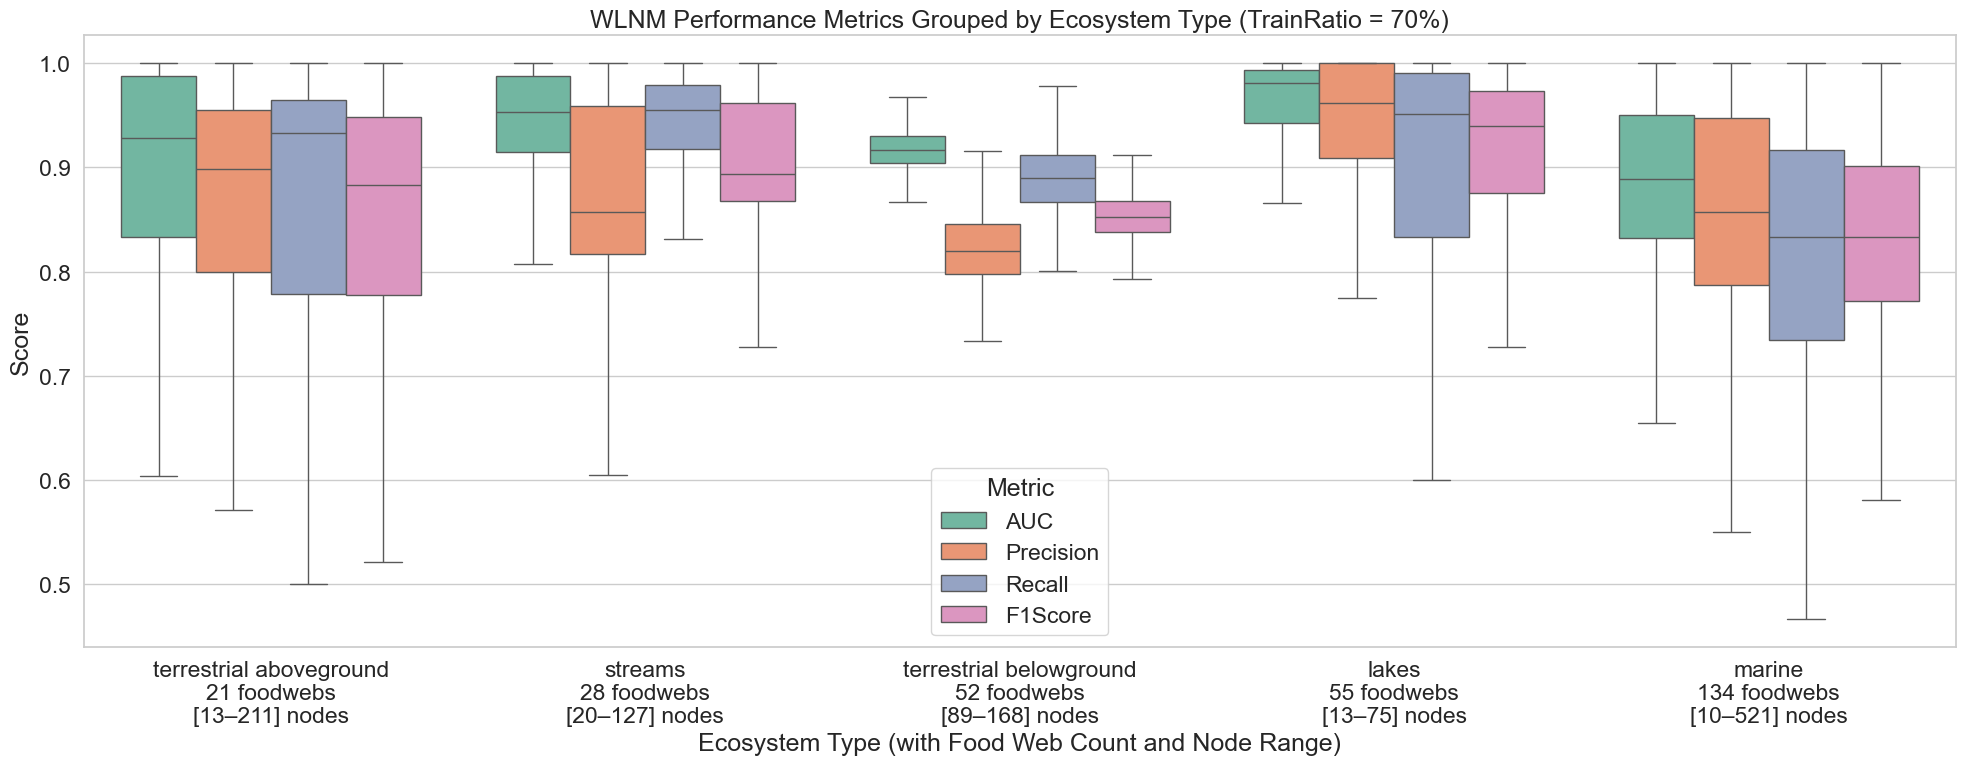

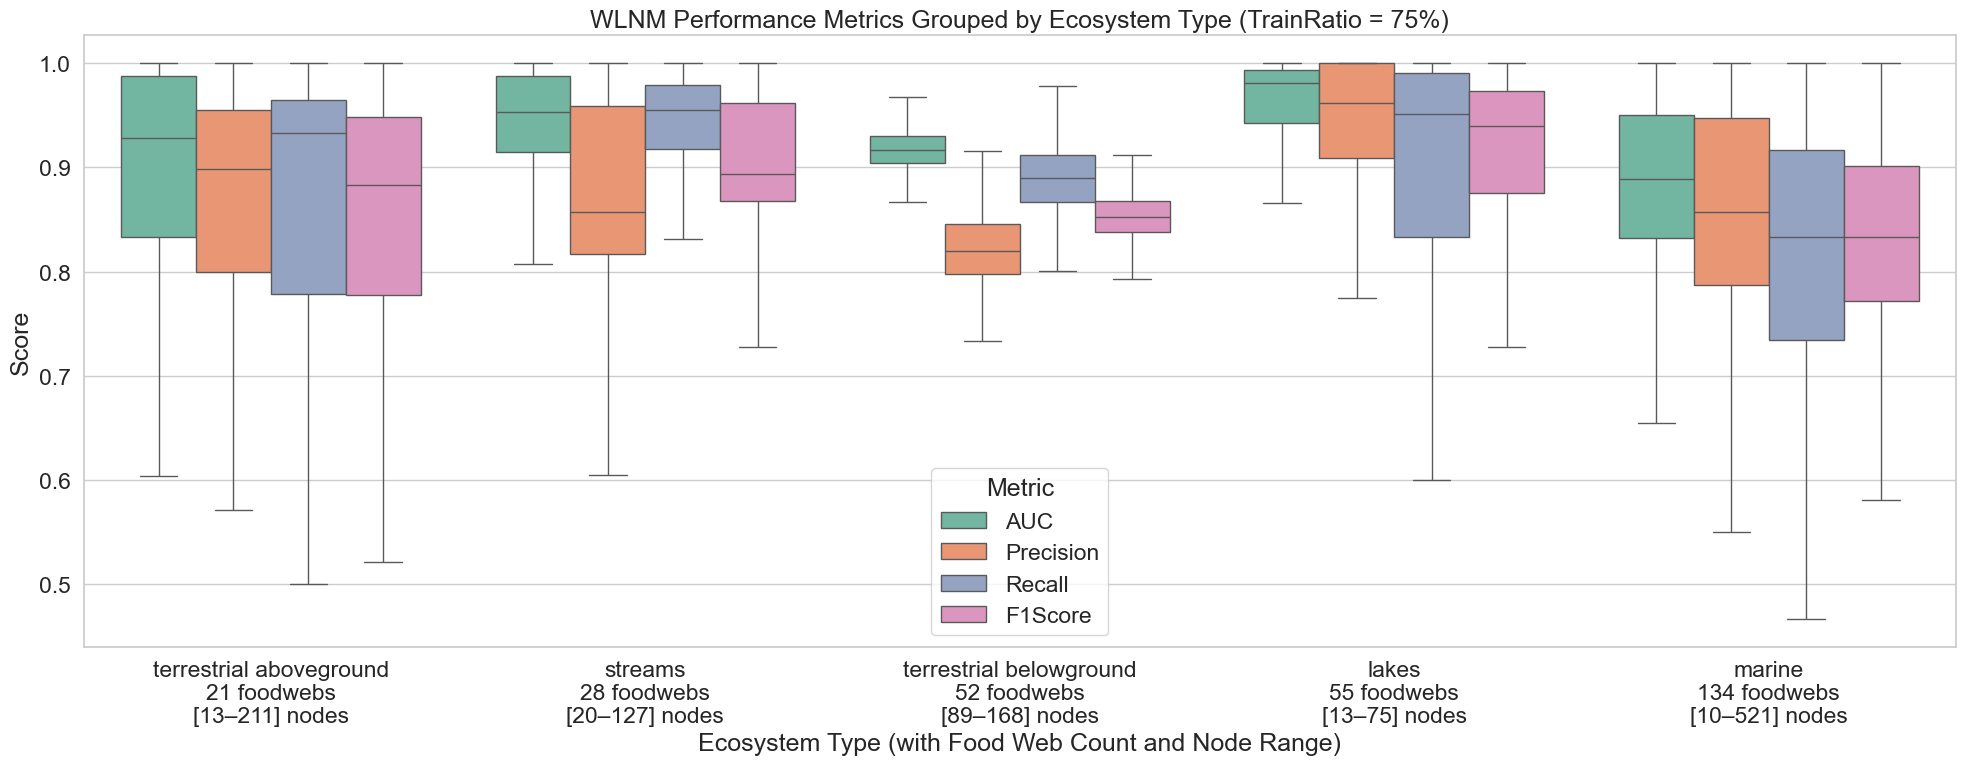

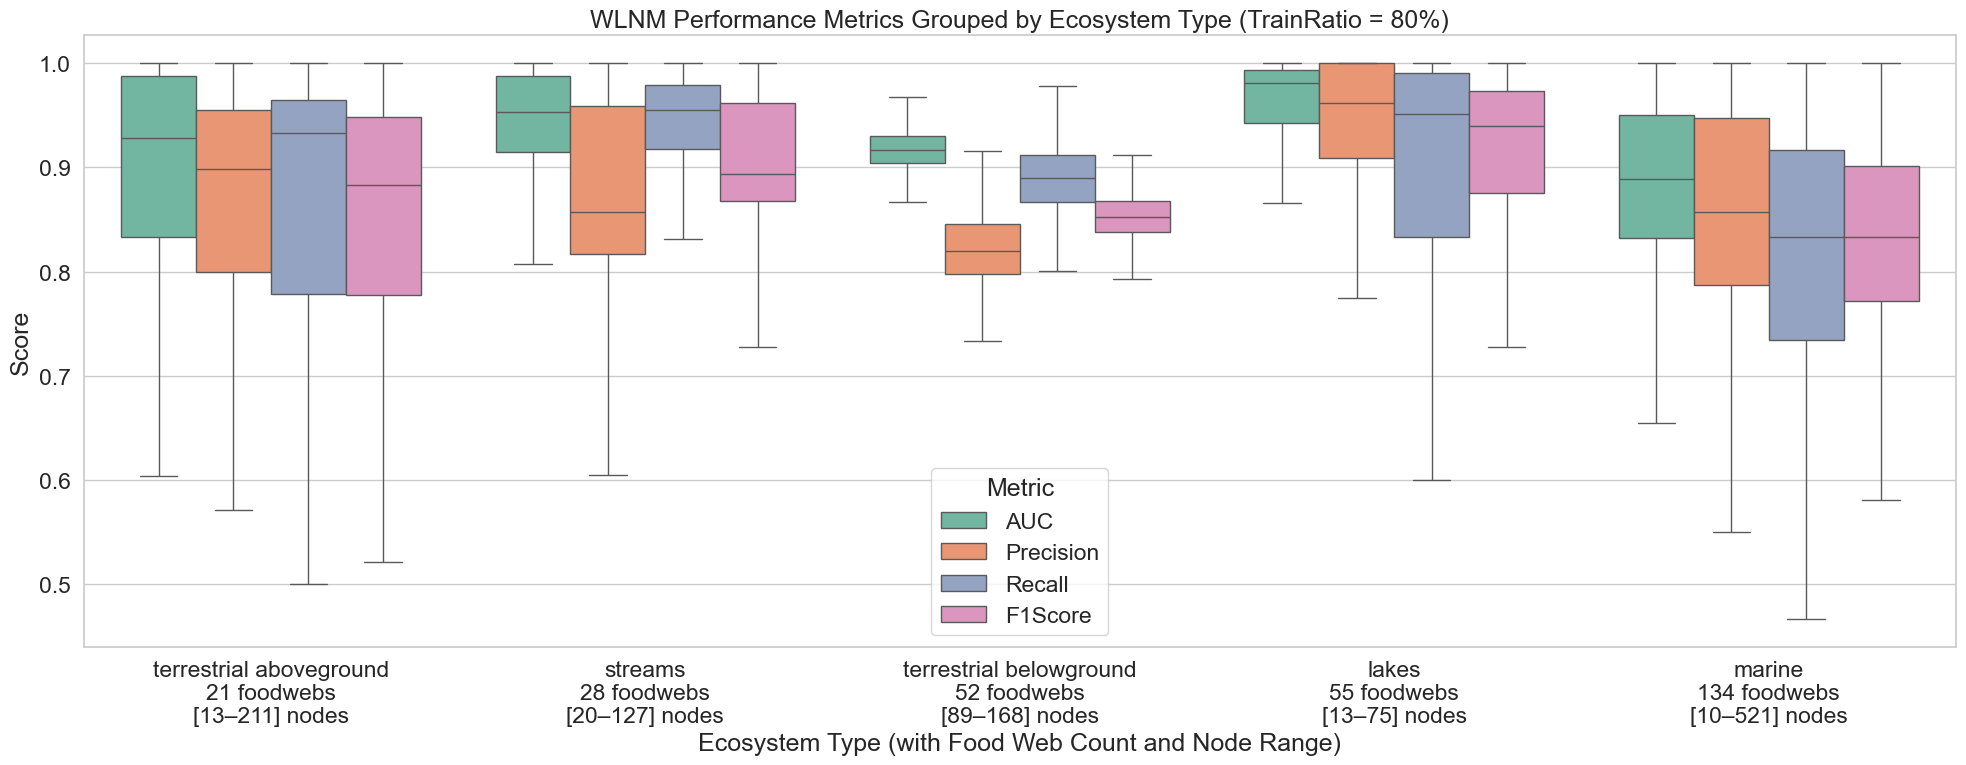

In [1]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results_dir = "../../src/matlab/data/result_sweep_train_ratios_290/prediction_scores_logs"
ecosystem_file = "../../src/matlab/data/foodwebs_mat/foodweb_metrics_ecosystem.csv"

ecosystem_labels = {
    "terrestrial aboveground": "terrestrial aboveground\n21 foodwebs\n[13–211] nodes",
    "streams": "streams\n28 foodwebs\n[20–127] nodes",
    "terrestrial belowground": "terrestrial belowground\n52 foodwebs\n[89–168] nodes",
    "lakes": "lakes\n55 foodwebs\n[13–75] nodes",
    "marine": "marine\n134 foodwebs\n[10–521] nodes"
}

ecosystem_order = [
    "terrestrial aboveground",
    "streams",
    "terrestrial belowground",
    "lakes",
    "marine"
]

custom_labels = [ecosystem_labels[eco] for eco in ecosystem_order]

df_ecosystem = pd.read_csv(ecosystem_file)

csv_files = glob.glob(os.path.join(results_dir, "*_results_random.csv"))
dfs = []

for file in csv_files:
    df = pd.read_csv(file)

    filename = os.path.basename(file)
    foodweb = filename.split("_results_")[0]

    df["Foodweb"] = foodweb
    dfs.append(df)

if not dfs:
    raise RuntimeError("No result CSV found. Check the path or pattern.")

df_all = pd.concat(dfs, ignore_index=True)

df_merged = pd.merge(df_all, df_ecosystem[["Foodweb", "ecosystem.type"]], on="Foodweb", how="left")

df_plot = df_merged.melt(
    id_vars=["Foodweb", "TrainRatio", "ecosystem.type", "Iteration"],
    value_vars=["AUC", "Precision", "Recall", "F1Score"],
    var_name="Metric",
    value_name="Value"
)

df_plot["TrainRatio"] = df_plot["TrainRatio"].astype(str)

ecosystem_order = (
    df_merged[["Foodweb", "ecosystem.type"]]
    .drop_duplicates()
    .groupby("ecosystem.type")
    .size()
    .sort_values()
    .index
    .tolist()
)

sns.set_theme(style="whitegrid", font_scale=1.5)
train_ratios = sorted(df_plot["TrainRatio"].unique())

for ratio in train_ratios:
    plt.figure(figsize=(20, 8))
    ax = sns.boxplot(
        data=df_plot,
        x="ecosystem.type",
        y="Value",
        hue="Metric",
        palette="Set2",
        showfliers=False,
        order=ecosystem_order,
    )

    ax.set_title(f"WLNM Performance Metrics Grouped by Ecosystem Type (TrainRatio = {ratio}%)")
    ax.set_ylabel("Score")
    ax.set_xlabel("Ecosystem Type (with Food Web Count and Node Range)")
    ax.set_xticks(range(len(ecosystem_order)))
    ax.set_xticklabels(custom_labels)
    plt.legend(title="Metric")
    plt.tight_layout()
    plt.show()

## 2. Rare Link - Based Training Split

### **1. Objective**

* The goal is to modify the way links are split into training and testing sets for WLNM.
* Instead of selecting training links completely at random, we introduce a strategy to **favor rare interactions**—links between nodes that are less connected in the food web.



### **2. Node Connectivity Measurement**

* For every species (node) in the food web, we calculate how connected it is by counting:

  * How many feeding links go **out** of the species (out-degree).
  * How many feeding links go **into** the species (in-degree).
* These two counts are combined into a single **degree measure** of connectivity.



### **3. Rarity Score for Each Link**

* Each feeding interaction (link) is given a **rarity score**, defined as the sum of the connectivity of the two species involved in the interaction.
* Links with **lower scores** represent interactions between less connected species, making them **rarer** from an ecological perspective.



### **4. Selecting Training Links**

* A fraction of the links is allocated for training according to the desired train/test ratio.
* Within this training set:

  * A certain **fraction (RareFraction)** is specifically chosen from the **rarest links**.
  * The remaining links are filled with randomly selected, more common interactions.
* This ensures that rare interactions are well represented in the training data while still including typical links.



### **5. Selecting Test Links**

* All links that are **not selected for training** are automatically placed in the testing set.
* This preserves the overall train/test ratio and ensures that the evaluation includes both rare and common links.



### **6. Adjustable RareFraction**

* The algorithm allows adjusting the RareFraction parameter (e.g., 10%, 20%, up to 50%).
* By sweeping this parameter, we can analyze how much including rare interactions in training influences the model’s predictive performance.



### **7. Final Outcome**

* The resulting training and testing sets maintain:

  * The correct overall train/test split ratio.
  * A tunable proportion of rare interactions in the training data.
* This strategy gives the model better exposure to less frequent ecological interactions, which may improve its ability to predict rare links.

---





### **1️. Random Strategy**

#### **Selection Logic**

* Extracts **all links** in the network (`linklist`).
* Randomly shuffles them (`randperm`).
* Iteratively removes links from `net` and places them into the test set until reaching `num_test`.
* Ensures (optional) that network connectivity remains (`hasPath`).
* Remaining links (not removed) become the training set.

#### **Output**

* `train` and `test` contain a representative random sample of links.



### **2. Rarelinks Strategy**

#### **Selection Logic**

* Computes **node rarity**:
  * `total_deg = out_degree + in_degree` for each node.

* Computes **edge rarity**:
  * `rarity_score = degree(u) + degree(v)` for every edge `(u, v)`.

* Sorts edges ascendingly (rarest first).
* Picks a fraction (`rare_fraction`) of the training set from **rarest edges**, the rest from others.
* Ensures that rare links are **over-sampled** in the training set.
* Test set = remaining links not chosen.

#### **Mathematical Behavior**

* Probability of a **rare link** being selected for training > probability of a high-degree link.
* Explicitly biases training to include low-degree nodes (rare interactions).
* Helps the model **learn to predict rare links**, which are often more difficult to infer.

### **Bias**

* **Biased sampling**: favors rare links.
* May cause:
  * Improved recall for rare interactions.
  * Slightly worse performance on common links (since fewer common edges are in training).

* Could lead to overfitting rare patterns if `rare_fraction` is too large.

### **Output**

* `train` contains intentionally **more rare links**.
* `test` likely has proportionally more common links.
* `train_nodes` and `test_nodes` explicitly list which nodes were included.



## **3. Comparison Table**

| Feature                | Random Strategy                      | Rarelinks Strategy                             |
| ---------------------- | ------------------------------------ | ---------------------------------------------- |
| **Selection Basis**    | Uniform random sampling              | Sorted by rarity (low-degree favored)          |
| **Probability**        | Equal for all edges                  | Higher for rare edges                          |
| **Training Diversity** | Balanced (proportional to frequency) | Biased toward rare interactions                |
| **Rare link coverage** | Might be underrepresented            | Overrepresented                                |
| **Impact on accuracy** | Good for overall metrics             | May improve rare link recall, affect precision |
| **Complexity**         | O(E) with simple loop                | O(E log E) (sorting rarity scores)             |
| **Connectivity check** | Optional path preservation           | Not currently checking connectivity            |
| **Best for**           | Baseline evaluation                  | Studying performance on rare links             |



## **4. When to Use**

* **Random** → Baseline, unbiased model performance, general AUC/F1.
* **Rarelinks** → When testing:

  * Model robustness for predicting **rare ecological interactions**.
  * How many rare links must be included in training to achieve certain accuracy.
  * Improvements in recall for low-degree species interactions.

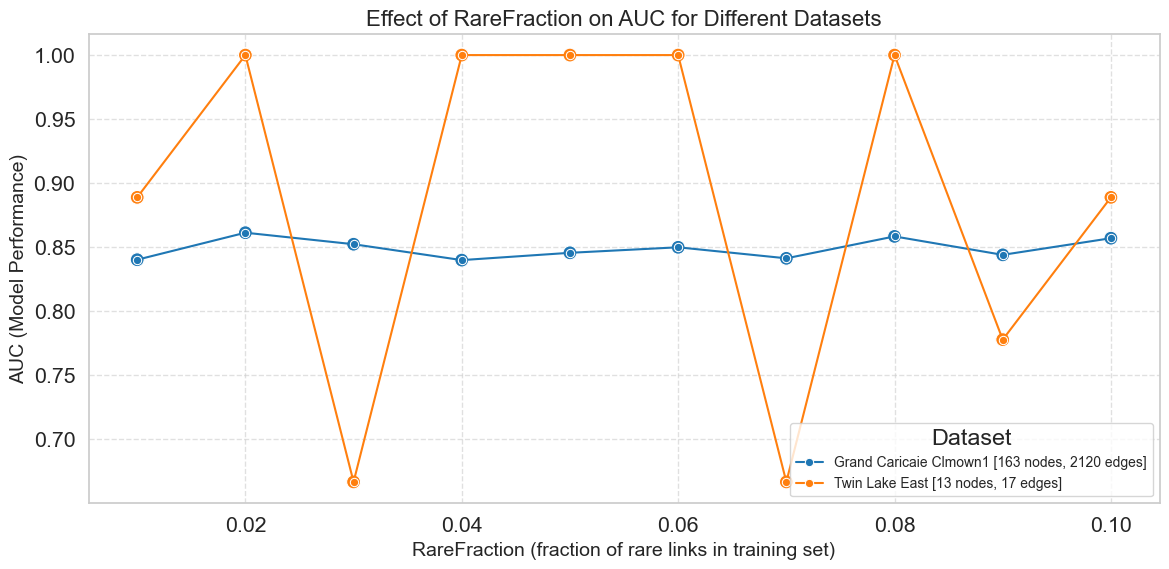

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

file1 = "../../src/matlab/data/result_rarelinks_30/prediction_scores_logs/Grand Caricaie  marsh dominated by Cladietum marisci, mown  Clmown1_tax_mass_results_rarelinks.csv"
file2 = "../../src/matlab/data/result_rarelinks_30/prediction_scores_logs/Twin Lake East_tax_mass_results_rarelinks.csv"

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

df1['Dataset'] = 'Grand Caricaie Clmown1 [163 nodes, 2120 edges]'
df2['Dataset'] = 'Twin Lake East [13 nodes, 17 edges]'

# Combine datasets
df = pd.concat([df1, df2], ignore_index=True)

# Ensure RareFraction is numeric
df['RareFraction'] = pd.to_numeric(df['RareFraction'], errors='coerce')

# === PLOT ===
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df,
    x='RareFraction',
    y='AUC',
    hue='Dataset',
    marker='o',
    palette='tab10'
)

# Add individual data points for clarity
sns.scatterplot(
    data=df,
    x='RareFraction',
    y='AUC',
    hue='Dataset',
    palette='tab10',
    s=100,
    legend=False
)

plt.title('Effect of RareFraction on AUC for Different Datasets', fontsize=16)
plt.xlabel('RareFraction (fraction of rare links in training set)', fontsize=14)
plt.ylabel('AUC (Model Performance)', fontsize=14)
plt.legend(loc='lower right', title='Dataset', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

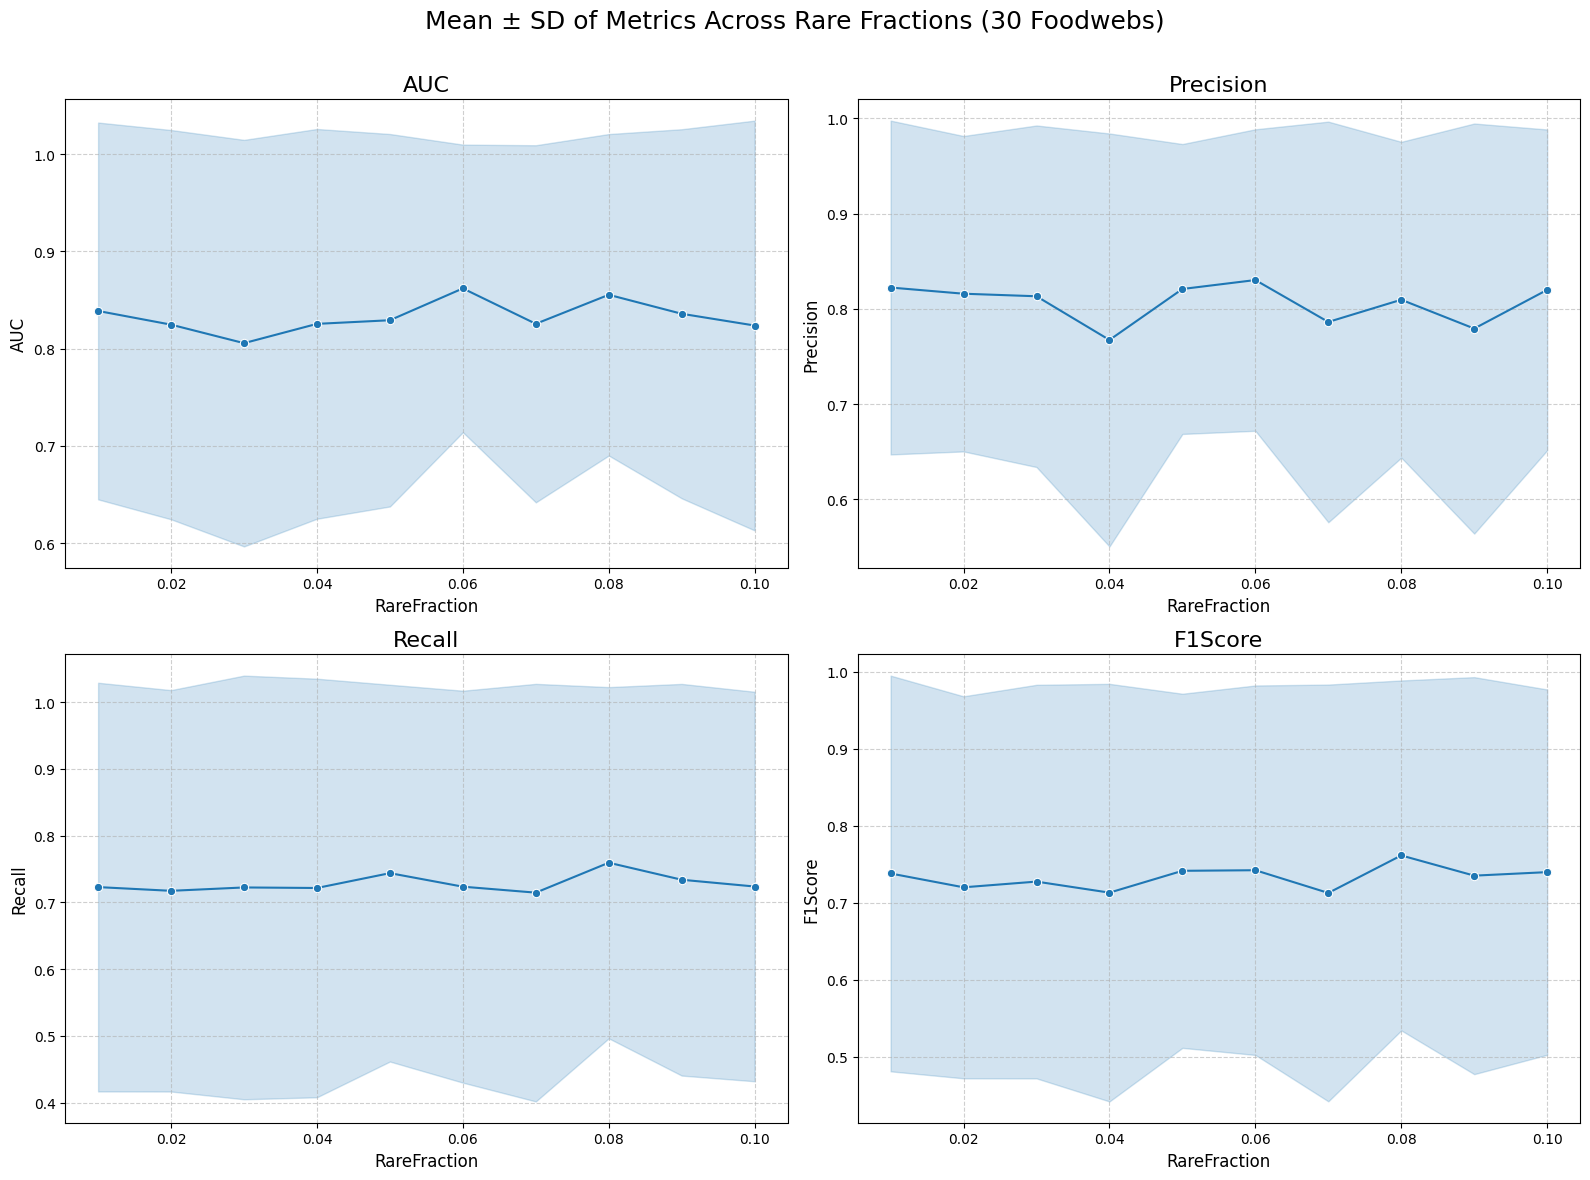

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os

# === CONFIG ===
results_dir = "../../src/matlab/data/result_rarelinks_30/prediction_scores_logs"

# === LOAD DATA ===
csv_files = glob.glob(os.path.join(results_dir, "*.csv"))

dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    if not df.empty and 'RareFraction' in df.columns:  # Avoid empty/all-NA files
        foodweb = os.path.basename(file).replace("_results_rarelinks.csv", "")
        df['Foodweb'] = foodweb
        dfs.append(df)

if not dfs:
    raise ValueError("No CSV files with 'RareFraction' found in the directory.")

df_all = pd.concat(dfs, ignore_index=True)

# Ensure RareFraction is numeric
df_all['RareFraction'] = pd.to_numeric(df_all['RareFraction'], errors='coerce')

# === PLOT: Mean ± SD for each metric ===
metrics = ['AUC', 'Precision', 'Recall', 'F1Score']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    sns.lineplot(
        data=df_all,
        x='RareFraction',
        y=metric,
        errorbar='sd',  # Updated
        marker='o',
        ax=axes[i]
    )
    axes[i].set_title(metric, fontsize=16)
    axes[i].set_xlabel('RareFraction', fontsize=12)
    axes[i].set_ylabel(metric, fontsize=12)
    axes[i].grid(True, linestyle='--', alpha=0.6)

plt.suptitle('Mean ± SD of Metrics Across Rare Fractions (30 Foodwebs)', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

### 1. **General Behavior**

* The **mean** lines (blue dots and connecting line) for AUC, Precision, Recall, and F1-Score remain **fairly stable** across rare fractions from 0.01 to 0.10.
* There is **no strong trend** of increasing or decreasing performance as more rare links are included in training.
* This suggests that within this range, the model is **robust** to changes in rare link inclusion.



### 2. **AUC**

* The AUC mean is consistently around **0.8–0.85**, which indicates **good discriminative ability**.
* The standard deviation is wide, meaning different food webs have varied performance.
* No rare fraction significantly improves AUC, suggesting diminishing returns beyond including \~1% rare links.



### 3. **Precision**

* Precision fluctuates slightly around **0.8–0.85**, but with occasional dips (especially at 0.04 and 0.08).
* The variance is **high**, which might indicate that in some food webs, rare links cause more false positives.
* The absence of a clear upward or downward trend means **rare links don't systematically help or hurt** precision.



### 4. **Overall Interpretation**

* Across 30 food webs, including a higher fraction of rare links in training does **not significantly alter** the predictive metrics.
* The **variance (blue shaded area)** is large, meaning model behavior differs widely by food web.
* Performance is relatively **robust** to rare fraction changes, but certain ecosystems might have more sensitivity.

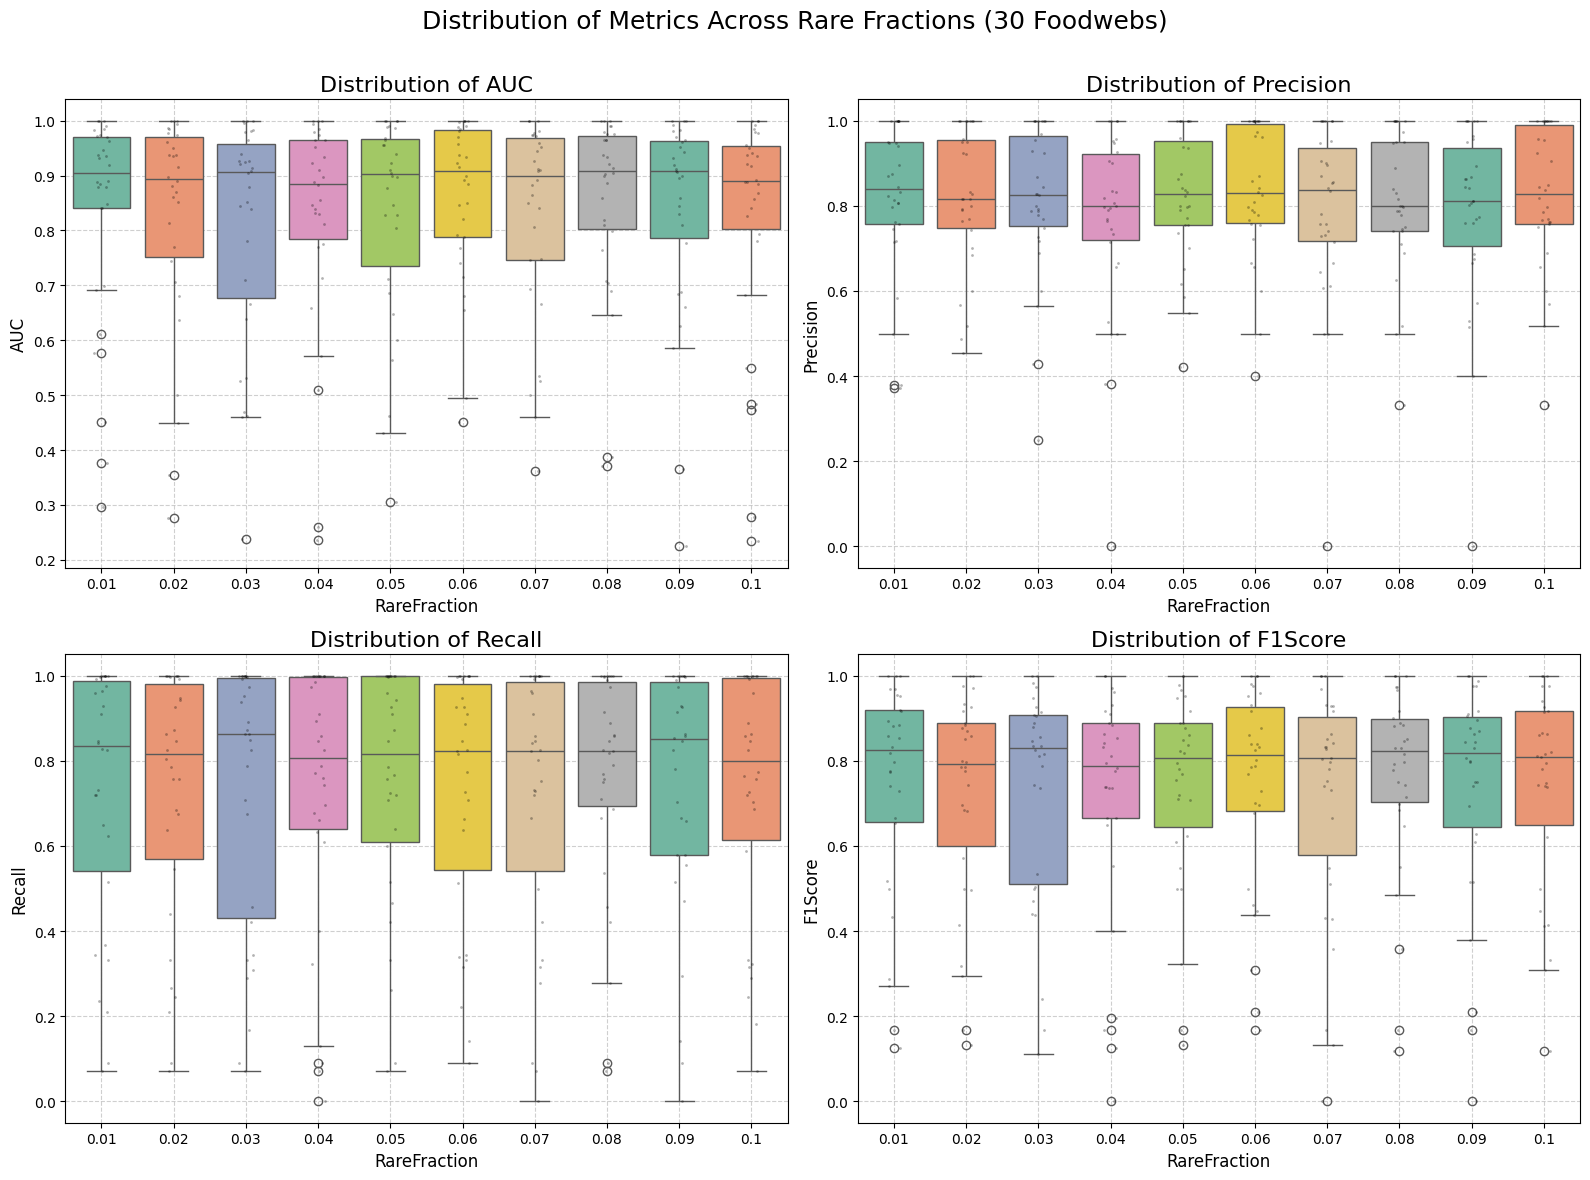

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os

# === CONFIG ===
results_dir = "../../src/matlab/data/result_rarelinks_30/prediction_scores_logs"

# === LOAD DATA ===
csv_files = glob.glob(os.path.join(results_dir, "*.csv"))

dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    if not df.empty and 'RareFraction' in df.columns:  # Only include rarelinks
        foodweb = os.path.basename(file).replace("_results_rarelinks.csv", "")
        df['Foodweb'] = foodweb
        dfs.append(df)

if not dfs:
    raise ValueError("No CSV files with 'RareFraction' found in the directory.")

df_all = pd.concat(dfs, ignore_index=True)
df_all['RareFraction'] = pd.to_numeric(df_all['RareFraction'], errors='coerce')

# === PLOT: Boxplots for distribution ===
metrics = ['AUC', 'Precision', 'Recall', 'F1Score']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    sns.boxplot(
        data=df_all,
        x='RareFraction',
        y=metric,
        ax=axes[i],
        hue='RareFraction',
        legend=False,
        palette="Set2",
    )
    sns.stripplot(
        data=df_all,
        x='RareFraction',
        y=metric,
        color='black',
        alpha=0.3,
        size=2,
        ax=axes[i]
    )
    axes[i].set_title(f'Distribution of {metric}', fontsize=16)
    axes[i].set_xlabel('RareFraction', fontsize=12)
    axes[i].set_ylabel(metric, fontsize=12)
    axes[i].grid(True, linestyle='--', alpha=0.6)

plt.suptitle('Distribution of Metrics Across Rare Fractions (30 Foodwebs)', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

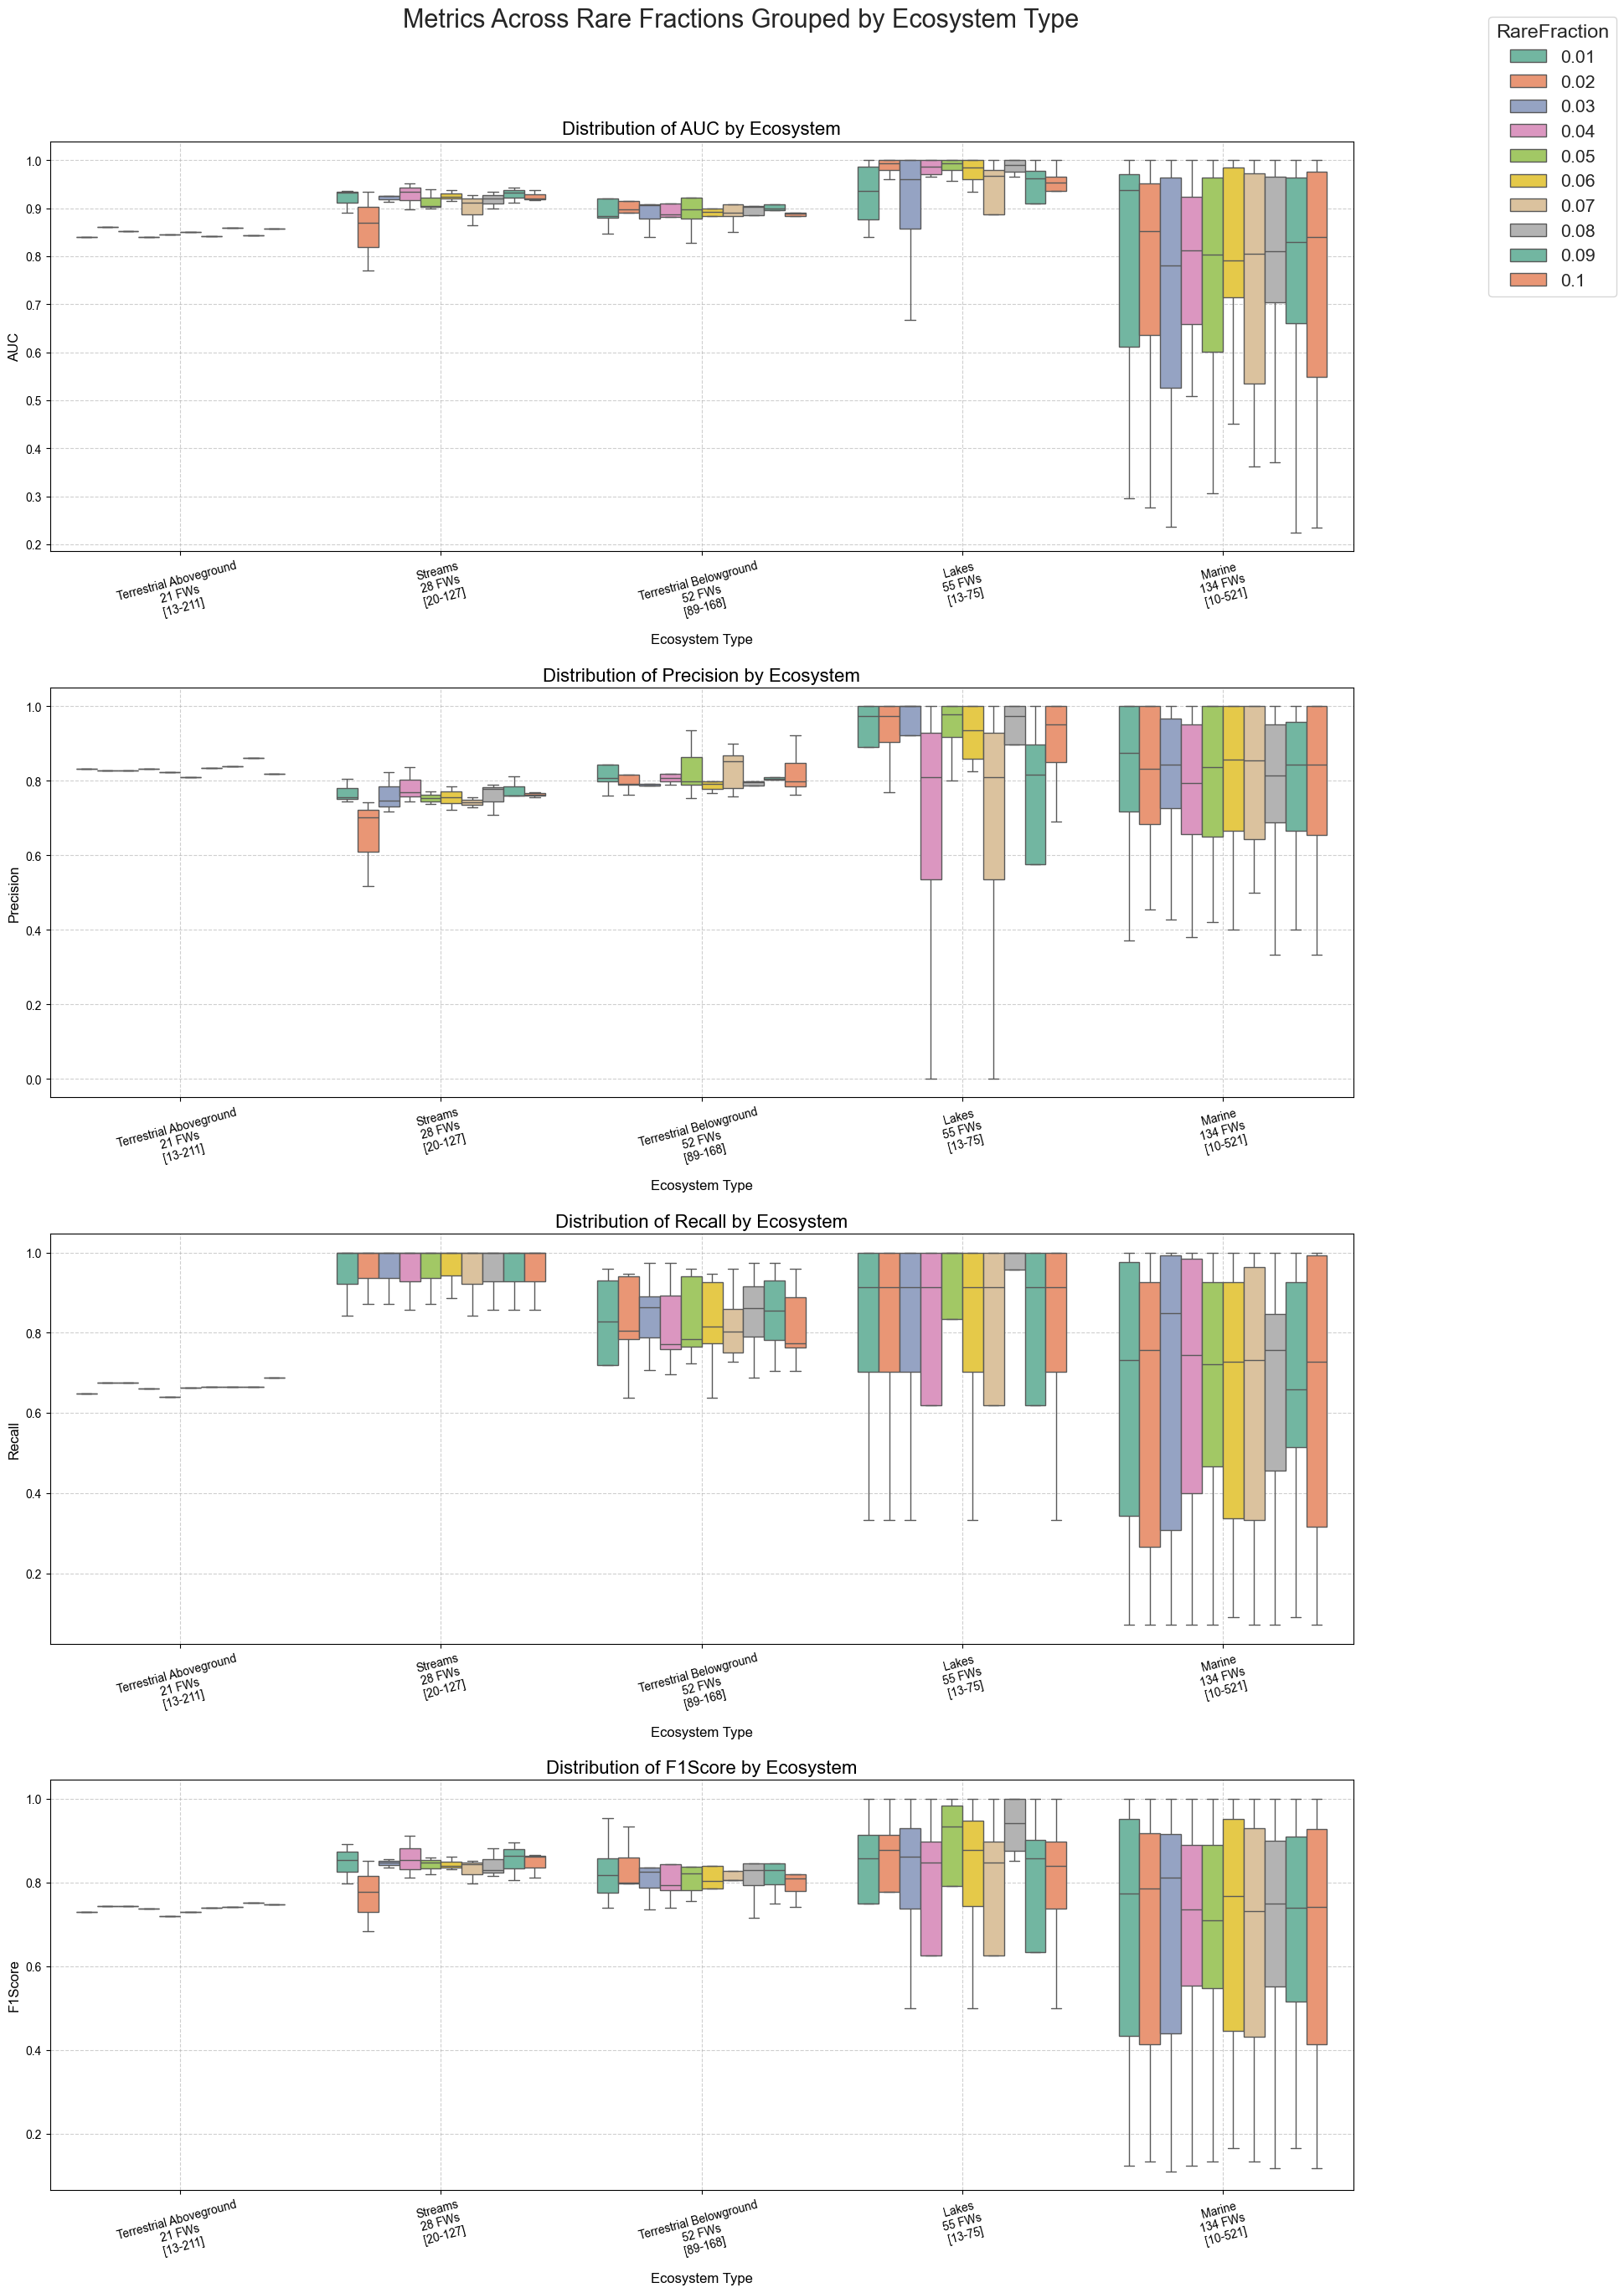

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os

# === CONFIG ===
results_dir = "../../src/matlab/data/result_rarelinks_30/prediction_scores_logs"
ecosystem_file = "../../src/matlab/data/foodwebs_mat/foodweb_metrics_ecosystem.csv"

# Custom labels and order for ecosystems
ecosystem_labels = {
    "terrestrial aboveground": "Terrestrial Aboveground\n21 FWs\n[13-211]",
    "streams": "Streams\n28 FWs\n[20-127]",
    "terrestrial belowground": "Terrestrial Belowground\n52 FWs\n[89-168]",
    "lakes": "Lakes\n55 FWs\n[13-75]",
    "marine": "Marine\n134 FWs\n[10-521]"
}
ecosystem_order = list(ecosystem_labels.keys())
custom_labels = [ecosystem_labels[eco] for eco in ecosystem_order]

# === LOAD DATA ===
df_ecosystem = pd.read_csv(ecosystem_file)

csv_files = glob.glob(os.path.join(results_dir, "*_results_rarelinks.csv"))
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    if not df.empty and 'RareFraction' in df.columns:
        foodweb = os.path.basename(file).replace("_results_rarelinks.csv", "")
        df['Foodweb'] = foodweb
        dfs.append(df)

if not dfs:
    raise ValueError("No CSV files with 'RareFraction' found in the directory.")

df_all = pd.concat(dfs, ignore_index=True)
df_all['RareFraction'] = pd.to_numeric(df_all['RareFraction'], errors='coerce')

# Merge ecosystem type info
df_merged = pd.merge(
    df_all,
    df_ecosystem[['Foodweb', 'ecosystem.type']],
    on='Foodweb',
    how='left'
)

# === PLOT: Boxplots grouped by ecosystem ===
metrics = ['AUC', 'Precision', 'Recall', 'F1Score']

fig, axes = plt.subplots(4, 1, figsize=(18, 28))  # 1 column, 4 rows
sns.set_theme(style="whitegrid", font_scale=1.4)

for i, metric in enumerate(metrics):
    sns.boxplot(
        data=df_merged,
        x='ecosystem.type',
        y=metric,
        hue='RareFraction',
        ax=axes[i],
        order=ecosystem_order,
        palette="Set2",
        showfliers=False
    )
    axes[i].set_title(f'Distribution of {metric} by Ecosystem', fontsize=16)
    axes[i].set_xlabel('Ecosystem Type', fontsize=12)
    axes[i].set_ylabel(metric, fontsize=12)

    # Fix tick labels
    tick_positions = range(len(ecosystem_order))
    axes[i].set_xticks(tick_positions)
    axes[i].set_xticklabels(custom_labels, rotation=15)

    axes[i].grid(True, linestyle='--', alpha=0.6)
    axes[i].get_legend().remove()

# Single legend for all plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="RareFraction", bbox_to_anchor=(0.99, 0.98), loc='upper left')

plt.suptitle('Metrics Across Rare Fractions Grouped by Ecosystem Type', fontsize=22)
plt.tight_layout(rect=[0, 0, 0.92, 0.96])
plt.show()